In [1]:
%matplotlib inline
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
# engine = create_engine("sqlite:///hawaii.sqlite")
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)


In [5]:
# reflect an existing database into a new model
# reflect the tables

Base = automap_base()
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Display the row's columns and data in dictionary format
first_row = session.query(measurement).first()
first_row.__dict__ 

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1236584fd90>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [10]:
# Create the inspector and connect it to the engine
# Using the inspector to print the column names within the 'measurement' table and its types

inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Display the row's columns and data in dictionary format
station = Base.classes.station
first_row2 = session.query(station).first()
first_row2.__dict__ 

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x123659552e0>,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'latitude': 21.2716,
 'elevation': 3.0,
 'longitude': -157.8168,
 'station': 'USC00519397'}

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
set_date = recent_date[0]

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

query_date = dt.date(2017,8,23) - dt.timedelta(days=365)
# print(query_date)


# Perform a query to retrieve the data and precipitation scores
data = session.query(measurement.date, measurement.prcp).\
        filter(measurement.date <= set_date).\
        filter(measurement.date >= query_date).\
        order_by(measurement.date.asc()).all()

print(data[:15])

[('2016-08-23', 0.0), ('2016-08-23', 0.15), ('2016-08-23', 0.05), ('2016-08-23', None), ('2016-08-23', 0.02), ('2016-08-23', 1.79), ('2016-08-23', 0.7), ('2016-08-24', 0.08), ('2016-08-24', 2.15), ('2016-08-24', 2.28), ('2016-08-24', None), ('2016-08-24', 1.22), ('2016-08-24', 2.15), ('2016-08-24', 1.45), ('2016-08-25', 0.08)]


In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(data, columns=['date', 'precipitation'])


# Sort the dataframe by date
df.sort_values(by='date', ascending=True, inplace=True)
# df.dropna(how='any',inplace=True)
df.set_index('date',inplace=True)

# print(len(df))
# df.dtypes
df

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.08
2017-08-23,0.00


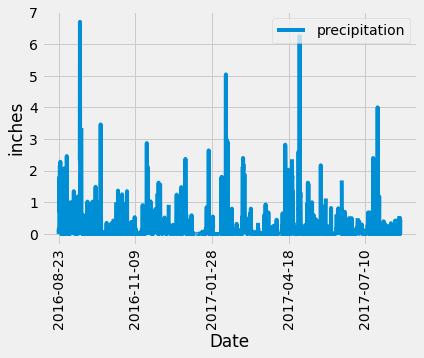

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90)
plt.xlabel("Date")
plt.ylabel("inches")
plt.legend(loc="upper right")
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()
# df.agg(["mean","median","var","std","sem"])

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
# session.query(func.count(station.station)).all()

station_count = session.query(measurement).group_by(measurement.station).count()
station_count


9

In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

station_count= session.query(measurement.station, func.count(measurement.id)).\
                group_by(measurement.station).\
                order_by(func.count(measurement.date).desc()).all()

station_active= session.query(measurement.station, func.count(measurement.id)).\
                group_by(measurement.station).\
                order_by(func.count(measurement.date).desc()).first()

print(f"Most active station is {station_active[0]}.")
print(station_count)

# for count in station_count:
#     print(count)

Most active station is USC00519281.
[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_temp= session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).\
                filter(measurement.station == station_active[0]).all()
station_temp

[(54.0, 85.0, 71.66378066378067)]

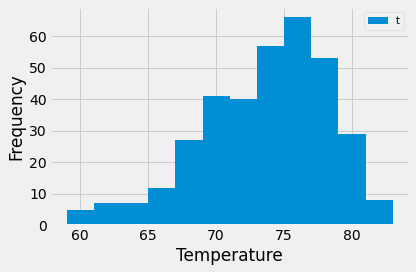

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temp = session.query(measurement.date, measurement.tobs).\
        filter(measurement.station == "USC00519281").\
        filter(measurement.date <= set_date).\
        filter(measurement.date >= query_date).\
        order_by(measurement.date.asc()).all()
station_temp

station_temp_df = pd.DataFrame(station_temp, columns=['date', 'tobs'])

plt.hist(station_temp_df["tobs"],bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend("tobs", loc="upper right",prop={'size': 10})
plt.tight_layout()
plt.show()

# Close session

In [21]:
# Close Session
session.close()